Requires install of pepnet (https://github.com/openvax/pepnet) and MHCFlurry (https://github.com/openvax/mhcflurry). 

## Read in Positive Binding Datasets 

In [44]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pepnet.encoder import Encoder

vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
mcpas_data = pd.read_csv('McPAS-TCR.csv', encoding = "ISO-8859-1")
# take only human data for now 
mcpas_data = mcpas_data[(mcpas_data['Species'] == 'Human') & 
                        pd.notnull(mcpas_data['MHC']) & 
                        pd.notnull(mcpas_data['CDR3.beta.aa']) & 
                        pd.notnull(mcpas_data['Epitope.peptide'])] 

mhc_i_regex = re.compile('HLA-.:*')
vdjdb_data = vdjdb_data[['CDR3', 'MHC A', 'MHC class', 'Epitope']].rename(columns={'MHC A': 'MHC'})
mcpas_data = mcpas_data[['CDR3.beta.aa', 'Epitope.peptide', 'MHC']].rename(
    columns={'CDR3.beta.aa' : 'CDR3', 'Epitope.peptide': 'Epitope'})
mcpas_data['MHC class'] = mcpas_data['MHC'].apply(lambda x: 'MHCI' if mhc_i_regex.match(x) else 'MHCII')
mcpas_data['CDR3'] = mcpas_data['CDR3'].str.upper()
mcpas_data['Epitope'] = mcpas_data['Epitope'].str.upper()

all_data = pd.concat([vdjdb_data, mcpas_data], ignore_index=True)
all_data = all_data[all_data['MHC class'] == 'MHCI']
all_data.drop(['MHC class'], axis=1, inplace=True)
all_data.drop_duplicates(inplace=True)
cdr3_length = all_data['CDR3'].apply(len)
peptide_length = all_data['Epitope'].apply(len)

print('Max CDR3 length = {}, Max peptide length = {}'.format(cdr3_length.max(), peptide_length.max()))
print('Number of examples: {}'.format(all_data.shape[0]))

Max CDR3 length = 38, Max peptide length = 20
Number of examples: 21446


/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 1.0, 'CDR3 Lengths')

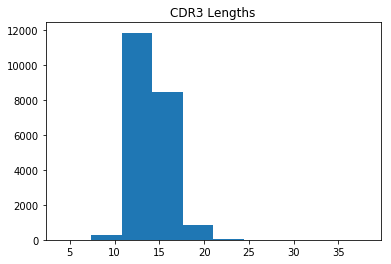

In [12]:
plt.hist(cdr3_length)
plt.title('CDR3 Lengths')

Text(0.5, 1.0, 'Peptide Lengths')

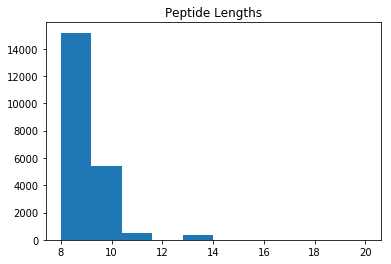

In [13]:
plt.hist(peptide_length)
plt.title('Peptide Lengths')

In [45]:
encoder = Encoder()
# for now only keep data points with CDR3 length <= 20 and epitope length <= 11
all_data = all_data[(all_data['CDR3'].str.len() <= 20) & 
                    (all_data['Epitope'].str.len() <= 11)]
cdr3_encoded = encoder.encode_onehot(all_data['CDR3'].values, max_peptide_length=20)
cdr3_encoded = cdr3_encoded.reshape((len(cdr3_encoded), -1))
epitope_encoded = encoder.encode_onehot(all_data['Epitope'].values, max_peptide_length=11)
epitope_encoded = epitope_encoded.reshape((len(epitope_encoded), -1))
combined_positive_peptides = np.concatenate((cdr3_encoded, epitope_encoded), axis=1)

## Create Negative Binding Data 

In [22]:
# right now, we create random epitopes, and assume that they do not bind to the CDR3 strands 
'''
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
training_set_size = 25000
lengths = [8, 9, 10, 11]
negative_epitopes = []
for length in lengths:
    epitopes_length = np.random.choice(amino_acids, 
                                       size=(training_set_size//len(lengths), length))
    epitopes_length = [''.join(aas) for aas in epitopes_length]
    negative_epitopes.extend(epitopes_length)

negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3 = np.random.choice(all_data['CDR3'].values, size=training_set_size)
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)
'''

In [46]:
# take our training data, and mutate them (assuming that TCR binding is sparse), and test
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
def point_mutate_epitope(epitope):
    mutation_index = np.random.randint(len(epitope))
    new_aa = amino_acids[np.random.randint(len(amino_acids))]
    mutated_epitope = epitope[:mutation_index] + new_aa + epitope[(mutation_index + 1):]
    return mutated_epitope

def mutate_epitope(epitope):
    num_mutations = np.random.randint(1, 4)
    mutation_indices = np.random.choice(np.arange(len(epitope)), num_mutations, replace=False)
    new_aas = {}
    for ind in mutation_indices:
        new_aas[ind] = amino_acids[np.random.randint(len(amino_acids))]
    mutated_epitope = ''
    for ind, aa in enumerate(epitope):
        if ind in mutation_indices:
            mutated_epitope += new_aas[ind]
        else:
            mutated_epitope += aa
    return mutated_epitope

#negative_epitopes = all_data['Epitope'].apply(point_mutate_epitope).values
negative_epitopes = all_data['Epitope'].apply(mutate_epitope).values
negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3 = all_data['CDR3'].values.copy()
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

## Train Model that determines whether the TCR strand attaches to Epitope

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

experiment_data = np.concatenate((combined_positive_peptides, 
                                  combined_negative_peptides), axis=0)
experiment_labels = np.concatenate((np.ones(len(combined_positive_peptides)), 
                                   np.zeros(len(combined_negative_peptides))), axis=0)
X_train, X_test, y_train, y_test = train_test_split(experiment_data, experiment_labels, 
                                                    test_size=0.25, random_state=42)
clf = RandomForestClassifier()
#clf = GradientBoostingClassifier()
#clf = LogisticRegression()
clf.fit(X_train, y_train)
print('Accuracy', clf.score(X_test, y_test))
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print('Confusion matrix', cm)

/home/alexander/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
